# Lab 11 (Evaluable)

We work for one of the most popular car buying and selling platforms in the world. From the product team they want to introduce a price recommender for the user based on the qualities of the car they want to sell. They have asked the Data Science team to tackle the challenge including:
- An exhaustive analysis of the data of the vehicles introduced in the platform in the past.
- The development of a predictive pricing model.
- The creation of a streamlit app that allows you to view the results of the analysis and interact with the model.
- Adding an explainability tab to the app so that all users can understand why each price is recommended to them.

# Practice Information:
**Due date:** By end of November, 28th (14h)

**Submission procedure:** via Moodle.

**Name:** Aniol Petit Cabarrocas

**NIA:** 266255

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from random import seed
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
#from xgboost import XGBRegressor
import lightgbm as lgb
import pickle

import warnings
warnings.simplefilter('ignore')

sns.set_palette("icefire")

### Read the Data

In [2]:
df = pd.read_csv("car_ad_display.csv", encoding = "ISO-8859-1", sep=";").drop(columns='Unnamed: 0')
df.head(3)

,car,price,body,mileage,engV,engType,registration,year,model,drive
0,Ford,15500.0,crossover,68,2.5,Gas,yes,2010,Kuga,full
1,Mercedes-Benz,20500.0,sedan,173,1.8,Gas,yes,2011,E-Class,rear
2,Mercedes-Benz,35000.0,other,135,5.5,Petrol,yes,2008,CL 550,rear


## Data Gathering and Data Wrangling

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8849 entries, 0 to 8848
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   car           8849 non-null   object 
 1   price         8849 non-null   float64
 2   body          8849 non-null   object 
 3   mileage       8849 non-null   int64  
 4   engV          8849 non-null   float64
 5   engType       8849 non-null   object 
 6   registration  8849 non-null   object 
 7   year          8849 non-null   int64  
 8   model         8849 non-null   object 
 9   drive         8467 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 691.5+ KB


In [6]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8467 entries, 0 to 8848
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   car           8467 non-null   object 
 1   price         8467 non-null   float64
 2   body          8467 non-null   object 
 3   mileage       8467 non-null   int64  
 4   engV          8467 non-null   float64
 5   engType       8467 non-null   object 
 6   registration  8467 non-null   object 
 7   year          8467 non-null   int64  
 8   model         8467 non-null   object 
 9   drive         8467 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 727.6+ KB


#### EX1: How many different entries do we have for the car names column?

In [ ]:
n_unique_cars = df['car'].nunique()
print("Number of different car names:", n_unique_cars)


Number of different car names: 83


**Solution:** There are 83 different entries in the car names column

#### Let's reduce the number of car names with a cutoff

In [4]:
def shorten_categories(categories, cutoff):
    categorical_map = {}
    for i in range(len(categories)):
        if categories.values[i] >= cutoff:
            categorical_map[categories.index[i]] = categories.index[i]
        else:
            categorical_map[categories.index[i]] = 'Other'
    return categorical_map

In [5]:
car_map = shorten_categories(df.car.value_counts(), 10)
df['car'] = df['car'].map(car_map)
df.car.value_counts()

car
Volkswagen       877
Mercedes-Benz    820
BMW              638
Toyota           510
VAZ              447
Renault          441
Audi             420
Opel             385
Skoda            351
Hyundai          348
Ford             329
Mitsubishi       307
Nissan           297
Chevrolet        234
Daewoo           213
Kia              207
Honda            200
Mazda            179
Peugeot          176
Lexus            162
Land Rover       134
Fiat             114
Subaru           107
Citroen          102
Other            101
ZAZ               91
Porsche           83
Infiniti          62
Suzuki            56
Geely             54
Smart             52
Chery             49
SsangYong         44
Seat              37
Volvo             32
Chrysler          25
Jeep              25
GAZ               24
UAZ               19
Jaguar            19
Bentley           15
MINI              15
Dodge             14
Acura             13
Alfa Romeo        11
Dacia             10
Name: count, dtype: int64

#### EX2: Do the same with car model feature!

In [11]:
model_map = shorten_categories(df.model.value_counts(), 10)
df['model'] = df['model'].map(model_map)
df.model.value_counts()

model
Other         1679
E-Class        178
A6             151
Camry          122
Vito ïàññ.     114
              ... 
Symbol          10
Sharan          10
S 550           10
207             10
Ibiza           10
Name: count, Length: 227, dtype: int64

#### EX3: Plot a bar char of the TOP 10 most expensive cars.
#### Which is the mean price per car brand?  (for the top 10 most expensive)

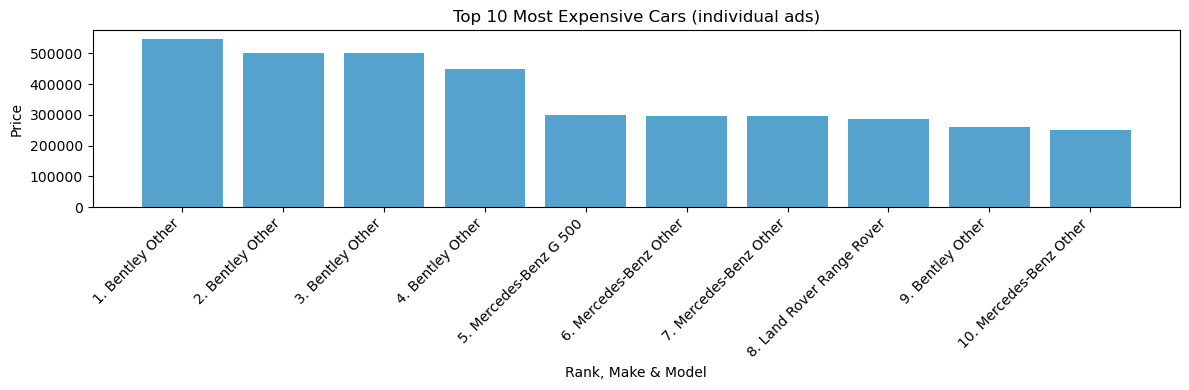

Top 10 most expensive cars (individual ads):
                          label            car        model     price
7008           1. Bentley Other        Bentley        Other  547800.0
7289           2. Bentley Other        Bentley        Other  499999.0
1444           3. Bentley Other        Bentley        Other  499999.0
3783           4. Bentley Other        Bentley        Other  449999.0
5364     5. Mercedes-Benz G 500  Mercedes-Benz        G 500  300000.0
1955     6. Mercedes-Benz Other  Mercedes-Benz        Other  295000.0
1704     7. Mercedes-Benz Other  Mercedes-Benz        Other  295000.0
7567  8. Land Rover Range Rover     Land Rover  Range Rover  285000.0
1319           9. Bentley Other        Bentley        Other  259000.0
490     10. Mercedes-Benz Other  Mercedes-Benz        Other  250000.0


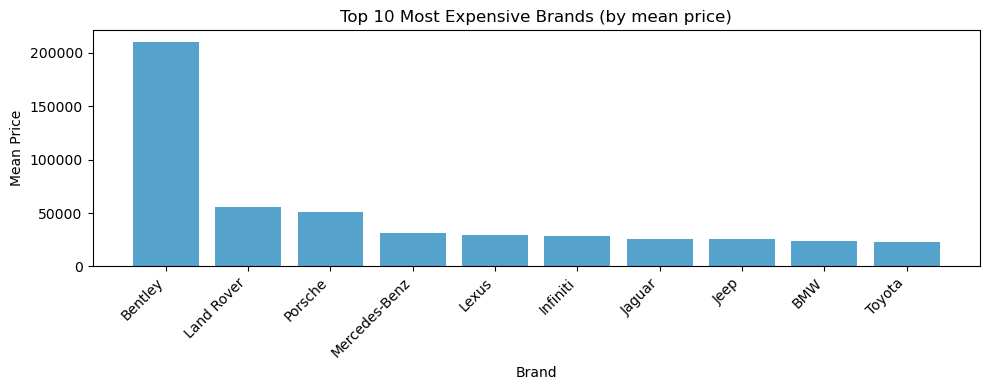

Most expensive brands by mean price (Top 10):
car
Bentley          210671.600000
Land Rover        55328.007519
Porsche           50535.658537
Mercedes-Benz     31282.764249
Lexus             29260.720000
Infiniti          28142.594000
Jaguar            25918.958333
Jeep              25647.520000
BMW               23680.733633
Toyota            22895.000409
Name: price, dtype: float64


In [15]:
# Plot 1: Top 10 most expensive individual cars (make + model) 
Top_10_cars = df.sort_values(by='price', ascending=False).head(10).copy()
Top_10_cars['label'] = [f"{i+1}. {row['car']} {row['model']}" for i, (_, row) in enumerate(Top_10_cars.iterrows())]

plt.figure(figsize=(12, 4))
plt.bar(Top_10_cars['label'], Top_10_cars['price'])
plt.title('Top 10 Most Expensive Cars (individual ads)')
plt.xlabel('Rank, Make & Model')
plt.ylabel('Price')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Display the full list for these 10 cars
print('Top 10 most expensive cars (individual ads):')
print(Top_10_cars[['label', 'car', 'model', 'price']])

# Plot 2: Top 10 most expensive brands by mean price 
brand_mean_prices = df.groupby('car')['price'].mean().sort_values(ascending=False)
Top_10_brands = brand_mean_prices.head(10)

plt.figure(figsize=(10, 4))
plt.bar(Top_10_brands.index, Top_10_brands.values)
plt.title('Top 10 Most Expensive Brands (by mean price)')
plt.xlabel('Brand')
plt.ylabel('Mean Price')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Display the full list (10) of most expensive brands by mean price
print('Most expensive brands by mean price (Top 10):')
print(Top_10_brands)


#### Let's analyze each variable distribution (except for car and model)

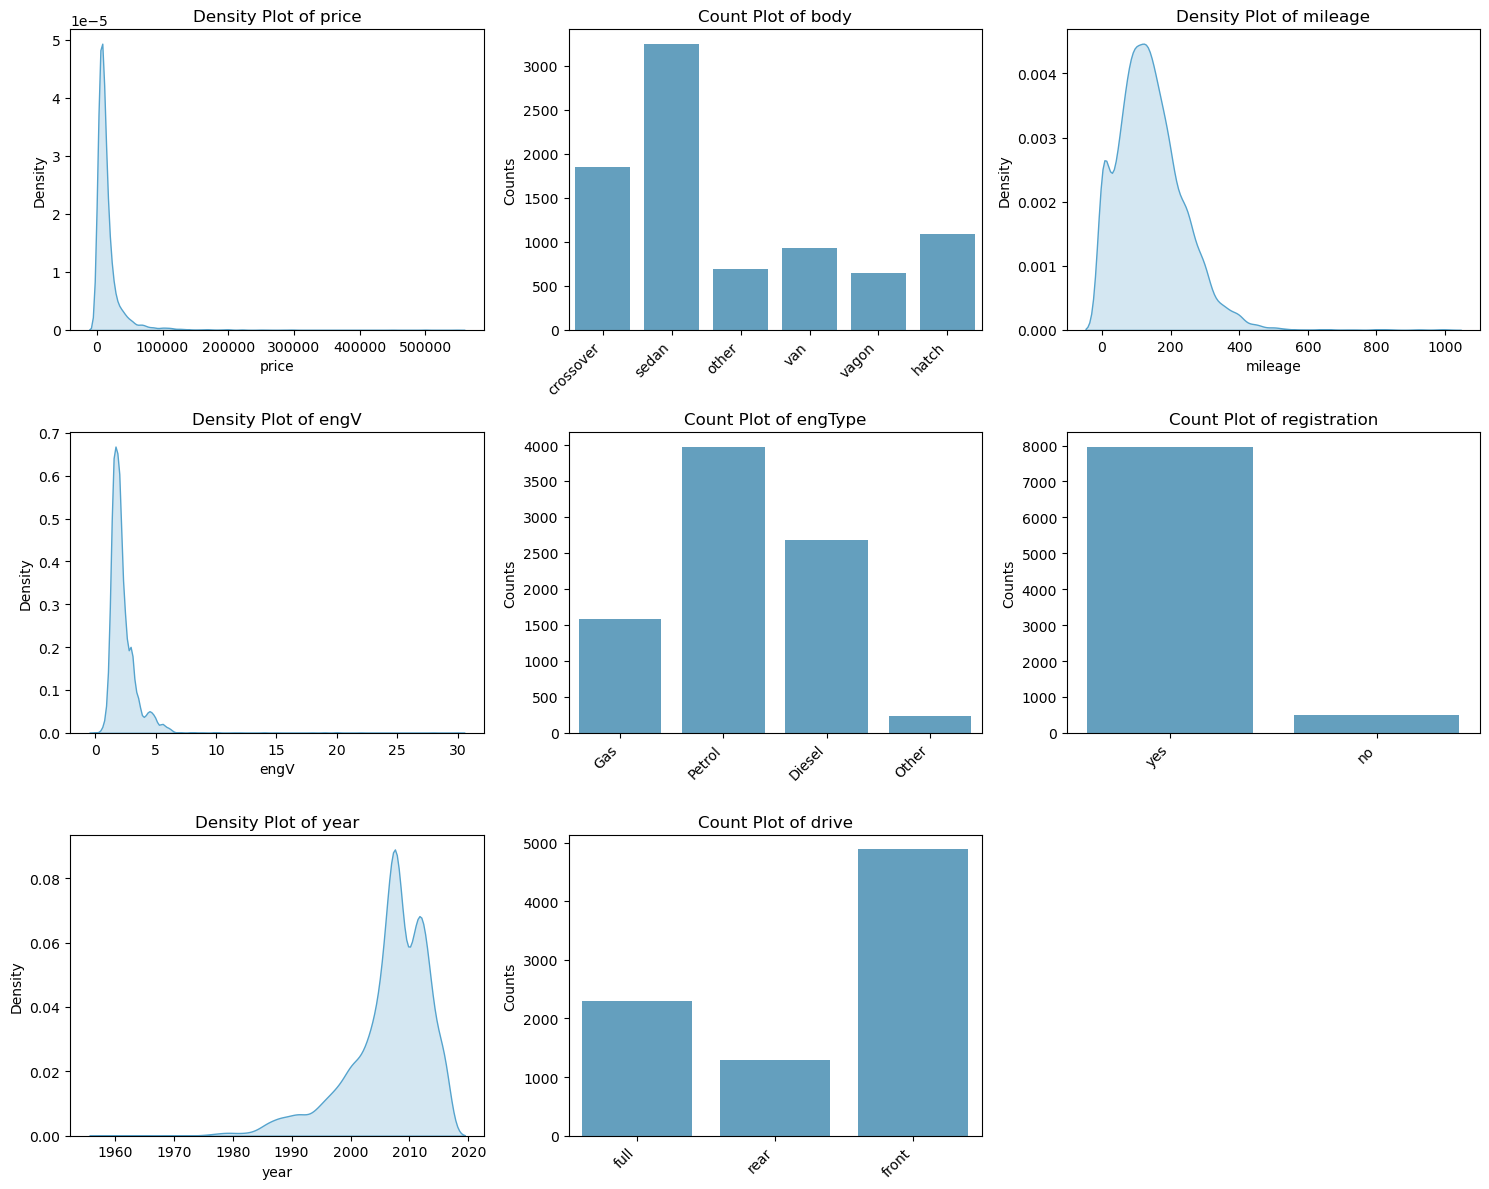

In [16]:
# Define the type of plot for each column based on the data type
plot_types = {}
columns = [x for x in df.columns if x not in ["car", "model"]]

for col in columns:
    if df[col].dtype == 'object':  # Categorical columns
        plot_types[col] = 'bar'
    else:
        unique_values = df[col].nunique()
        if unique_values < 10:  # Discrete columns
            plot_types[col] = 'bar'
        else:  # Continuous columns
            plot_types[col] = 'kde'

n_cols = 3
n_rows = (len(columns) + 2) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

# Plot each column in the dataframe
for i, col in enumerate(columns):
    ax = axes[i]
    if plot_types[col] == 'bar':
        # For categorical and discrete data, use a count plot (bar chart)
        sns.countplot(x=col, data=df, ax=ax)
        ax.set_title(f'Count Plot of {col}')
        ax.set_xlabel('')
        ax.set_ylabel('Counts')
        plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    else:
        # For continuous data, use a density plot
        sns.kdeplot(df[col], ax=ax, fill=True)
        ax.set_title(f'Density Plot of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Density')

# Hide any unused subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

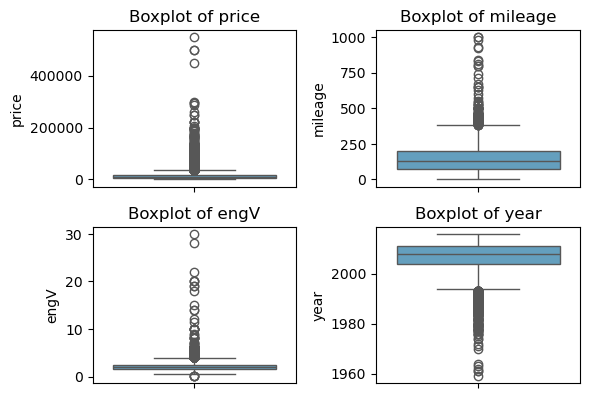

In [17]:
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

n_cols = 2
n_rows = (len(numeric_columns) + 2) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 2))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.boxplot(y=col, data=df, ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')

for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

#### Let's analyze each variable behaviour with respect to the target (price)

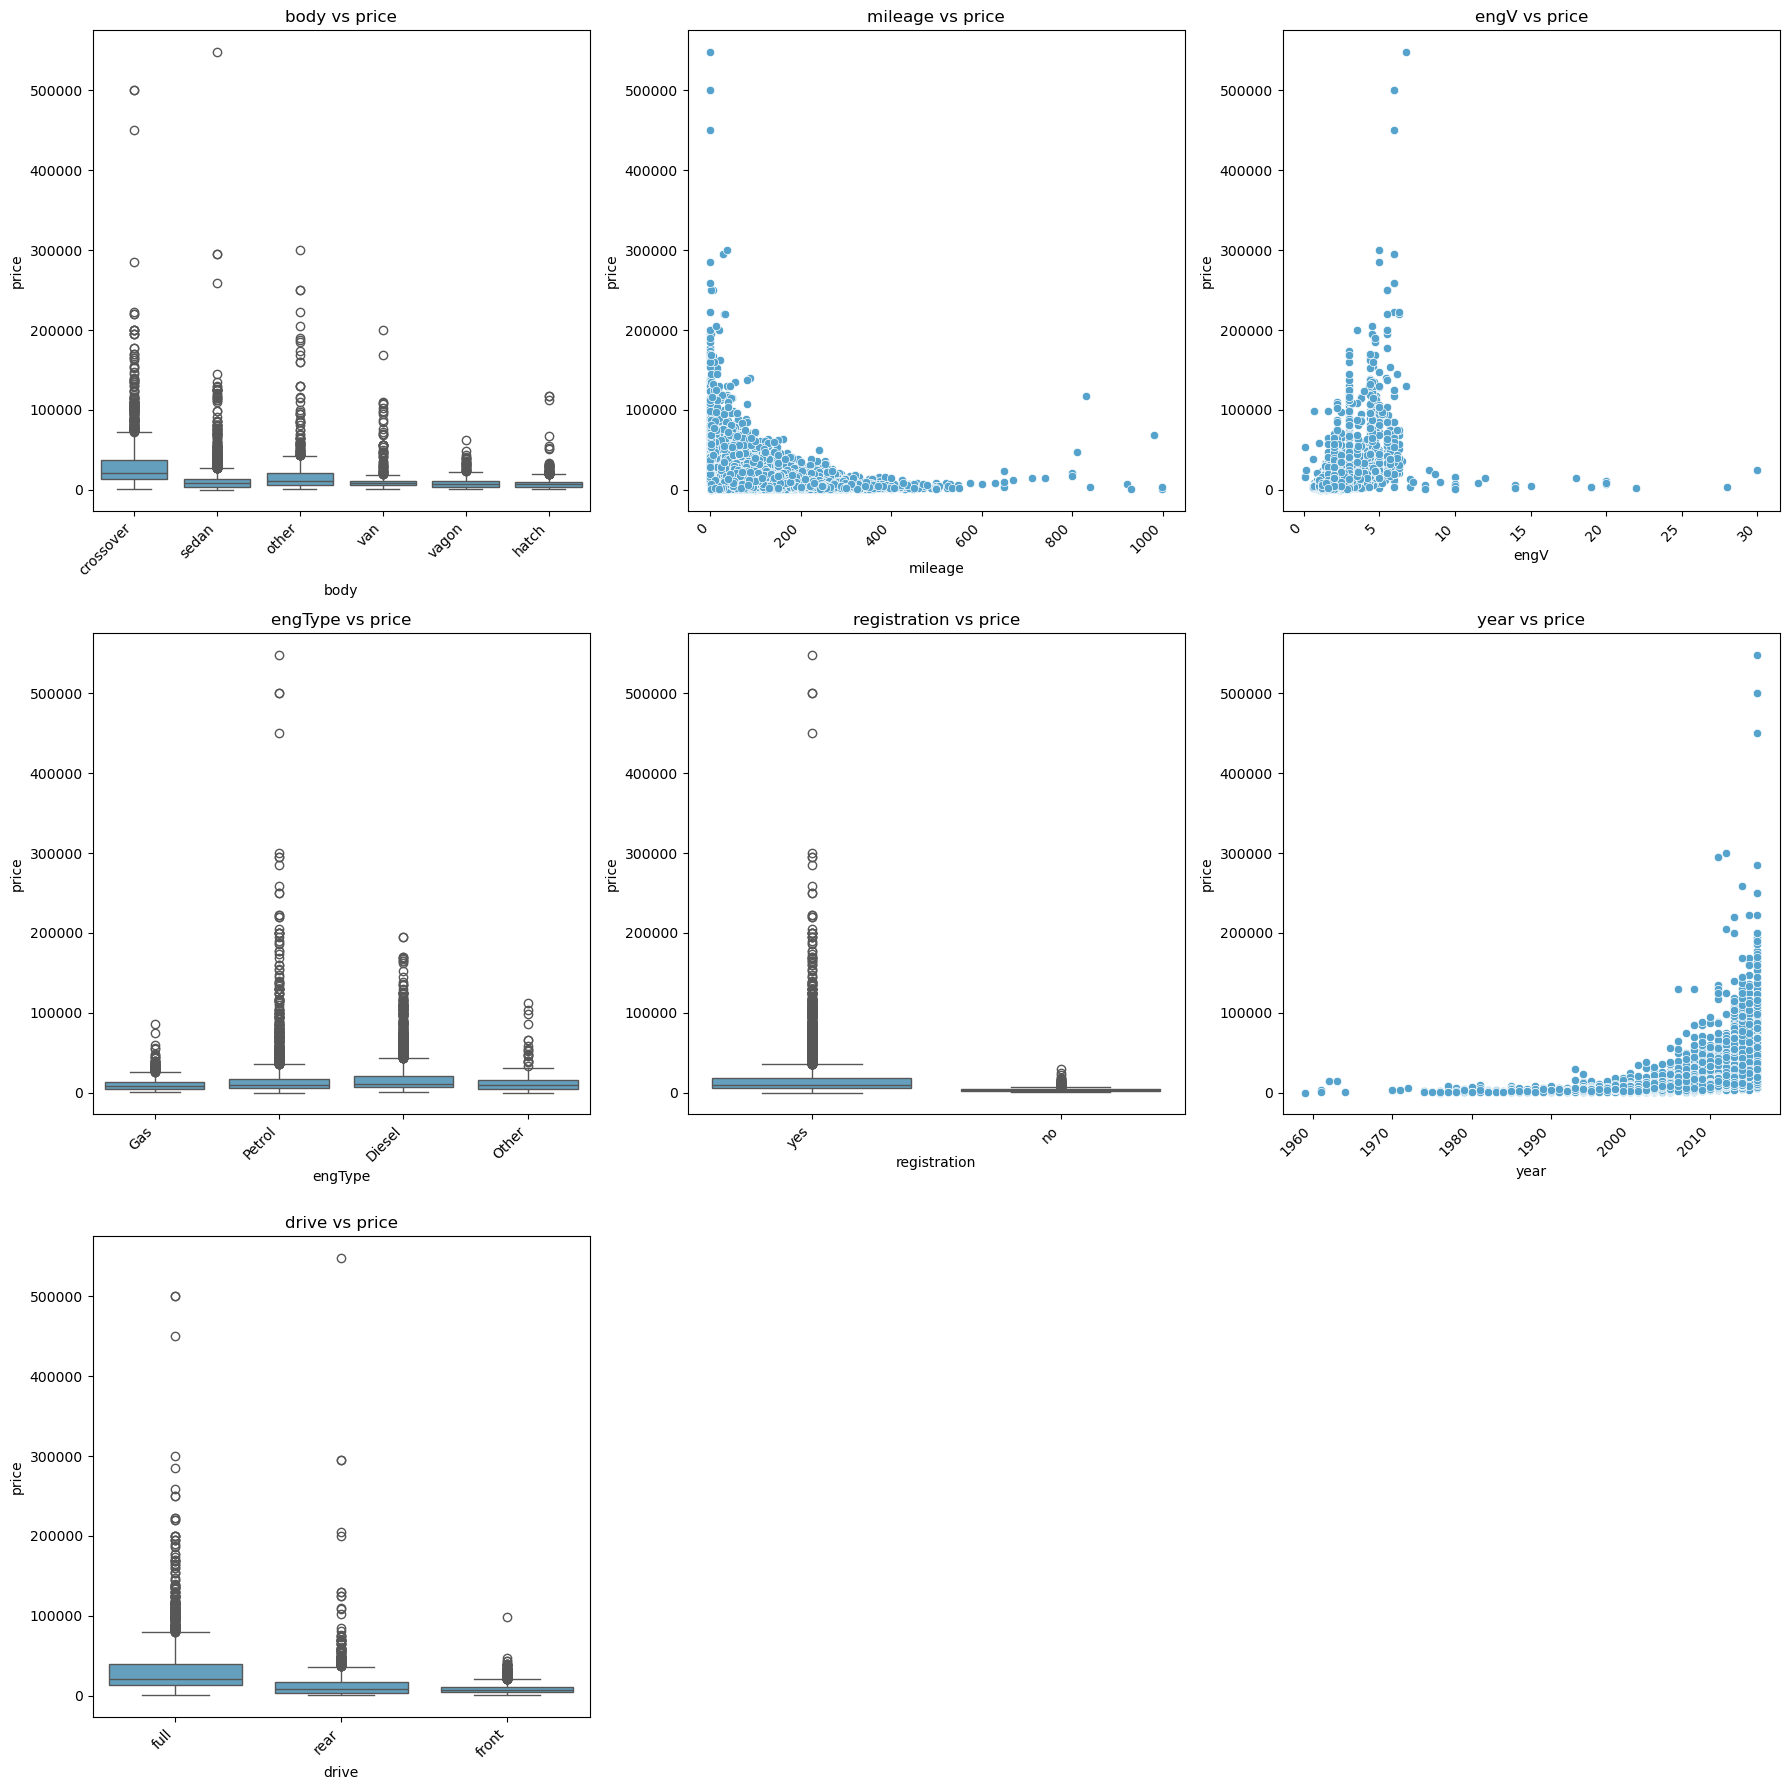

In [18]:
target = 'price'
features = [x for x in df.columns if x not in ["car", "model", target]]

n_cols = 3
n_rows = (len(features) + 2) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 6))
axes = axes.flatten()

# Plot each feature against the target variable in the dataframe
for i, feature in enumerate(features):
    ax = axes[i]
    if df[feature].dtype == 'object' or df[feature].nunique() < 10:
        # For categorical data, use a boxplot or violin plot
        sns.boxplot(x=feature, y=target, data=df, ax=ax)
    else:
        # For numerical data, use a scatter plot
        sns.scatterplot(x=feature, y=target, data=df, ax=ax)
    ax.set_title(f'{feature} vs {target}')
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

# Hide any unused subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

#### As we see, there are many outliers in the features and in the target data.
#### Let's get rid of outliers in the target

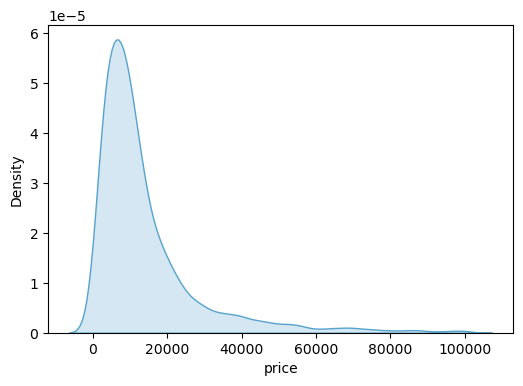

In [19]:
#Let's filter the prices between 1K and 100K
df = df[df["price"] <= 100000]
df = df[df["price"] >= 1000]

plt.figure(figsize=(6, 4))
sns.kdeplot(x="price", data=df, fill=True)
ax.set_title(f'Count Plot of Price')
plt.show()

#### Let's get rid of outliers in the rest of the numeric features

In [20]:
#Let's filter the mileage over 600
df = df[df["mileage"] <= 600]

#Let's filter the engV over 7.5
df = df[df["engV"] <= 7.5]

#Let's filter the year over 1975
df = df[df["year"] >= 1975]

#### Check how the behaviour of the features with the target has changed

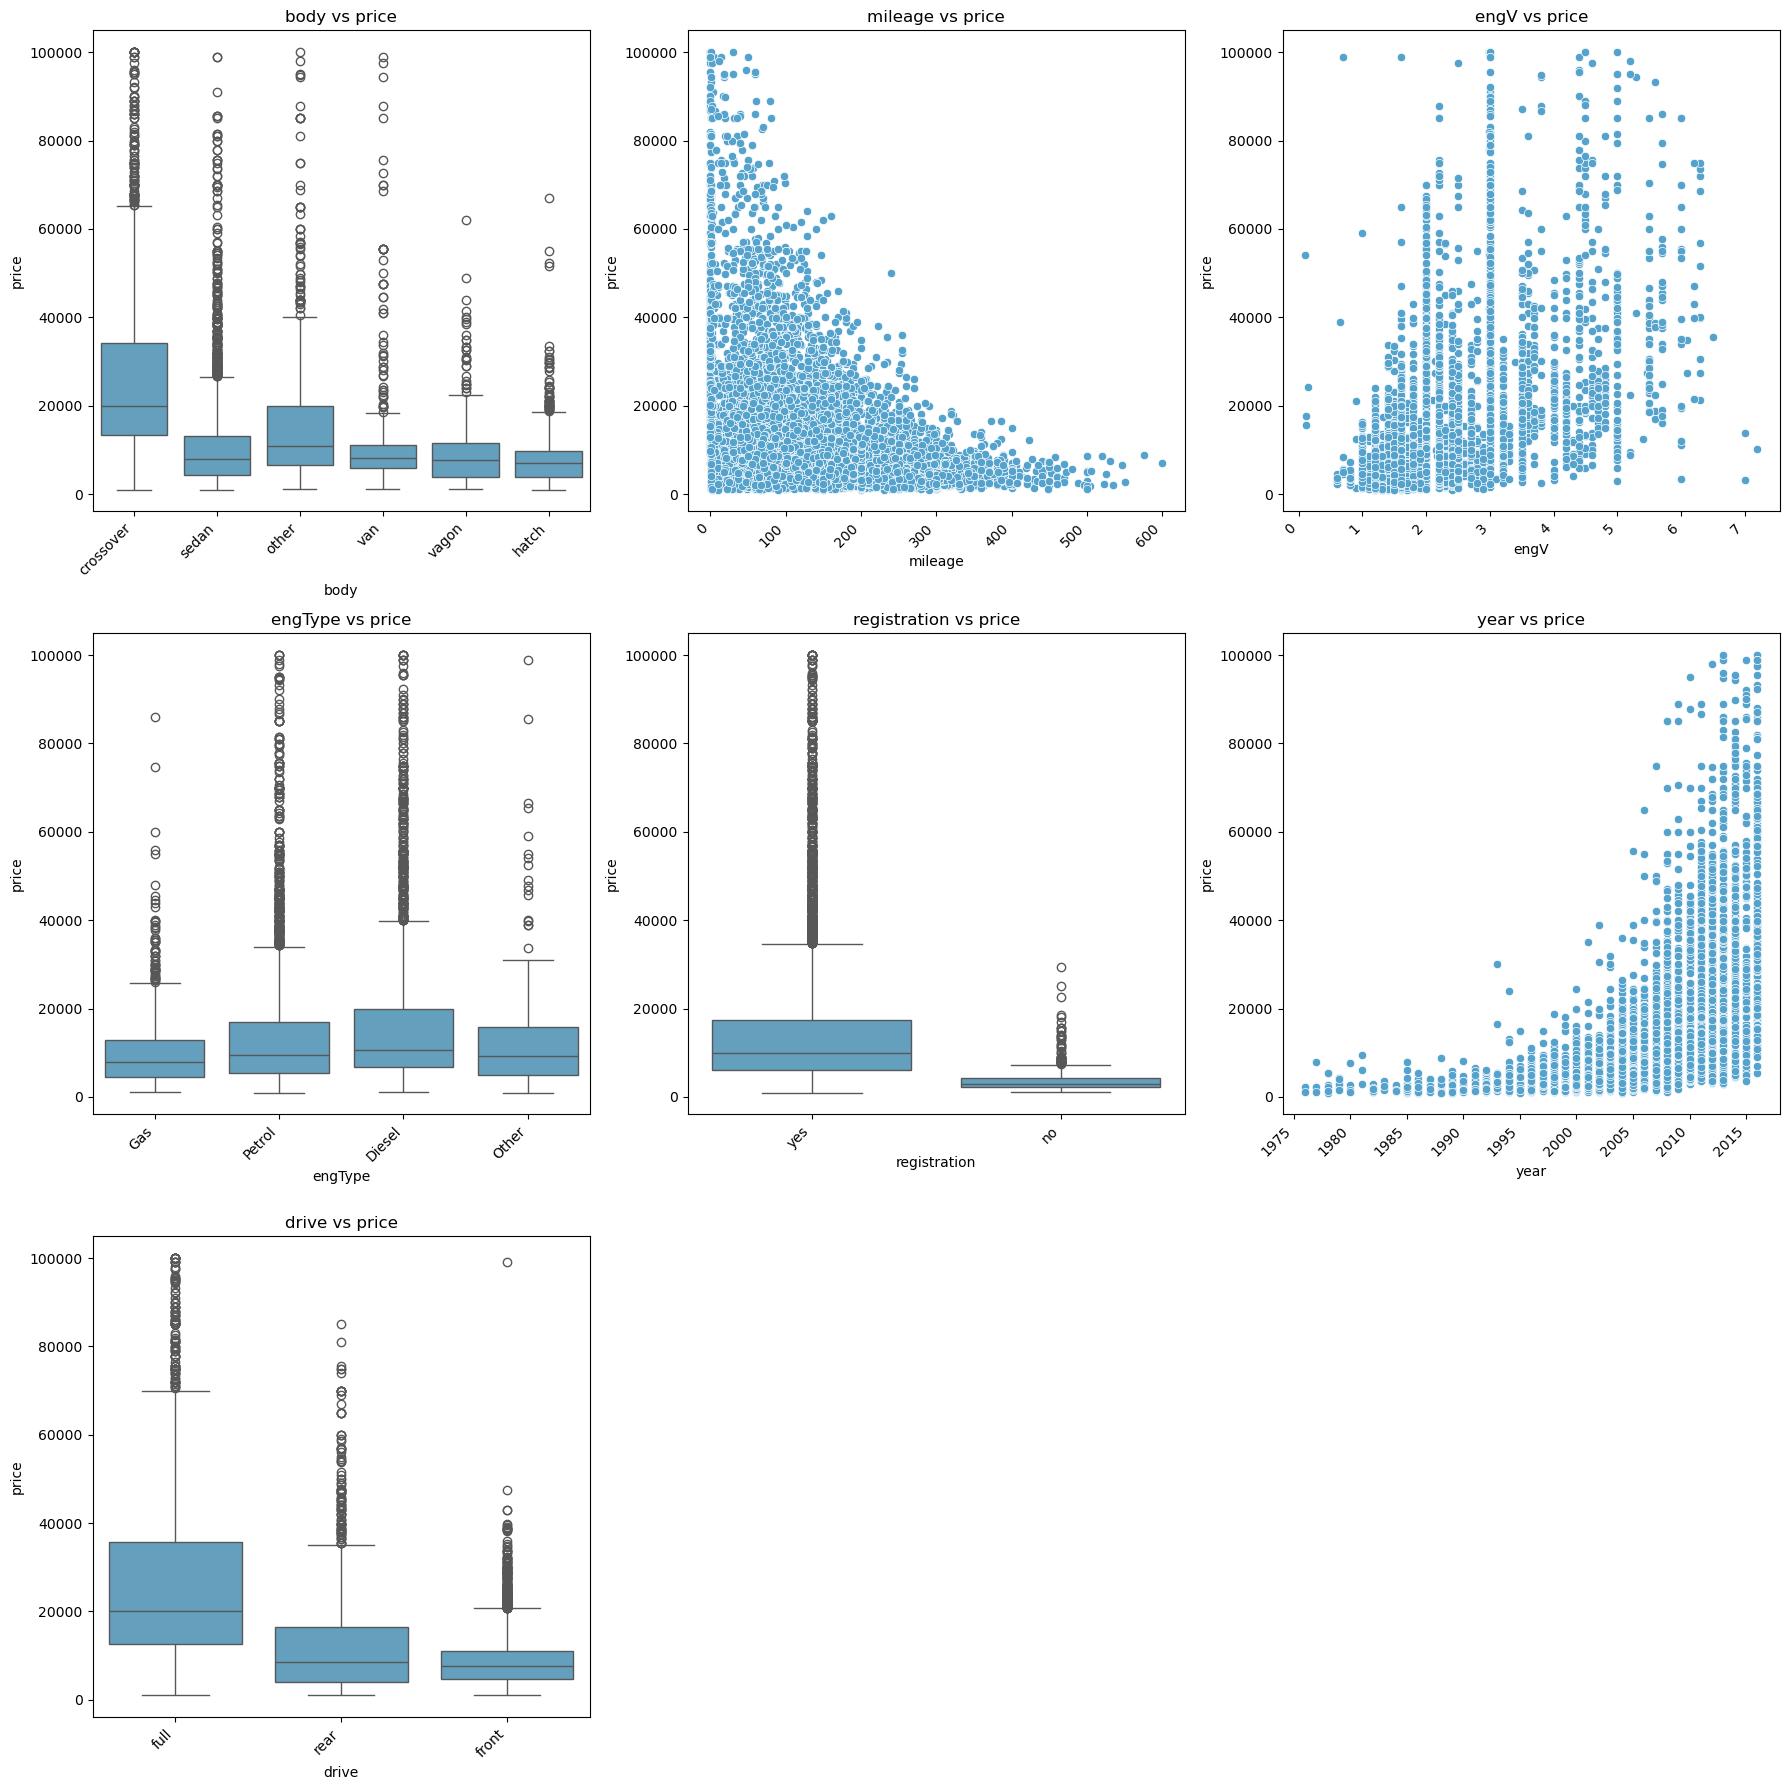

In [ ]:
target = 'price'
features = [x for x in df.columns if x not in ["car", "model", target]]

n_cols = 3
n_rows = (len(features) + 2) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 6))
axes = axes.flatten()

# Plot each feature against the target variable in the dataframe
for i, feature in enumerate(features):
    ax = axes[i]
    if df[feature].dtype == 'object' or df[feature].nunique() < 10:
        # For categorical data, use a boxplot or violin plot
        sns.boxplot(x=feature, y=target, data=df, ax=ax)
    else:
        # For numerical data, use a scatter plot
        sns.scatterplot(x=feature, y=target, data=df, ax=ax)
    ax.set_title(f'{feature} vs {target}')
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

# Hide any unused subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

#### EX4: Which of the features do you predict would be more important for estimating the price?

**Solution:** From the previous plots, the variables that seem most important for estimating price are **year**, **mileage**, **engV**, and the brand (**car**).

Newer cars are consistently placed at the higher end of the price range, which makes sense because a newer car usually has less wear, incorporates newer technology, and is perceived as more reliable, while for a given year and brand, cars with higher mileage tend to be cheaper, reflecting the fact that more kilometers driven imply more usage and expected maintenance costs. 

Cars with larger engines (engV) are, on average, more expensive; this likely captures both performance (powerful engines) and the fact that high-end models often come with larger engines, and even if the visual relationship seen in the plot is not perfectly linear, and is a bit more noisy than with other variables, the overall trend suggests that engine size contributes positively to price. 

Finally, premium brands (for example luxury or sports brands) systematically occupy higher price regions than more mainstream brands, even when informally controlling for year and mileage, which indicates that brand carries an intrinsic value (reputation, perceived quality, design, etc.). 

Other variables such as engType, drive, and registration might still have some effect (for example, certain drive types or registered cars may be slightly more expensive), but visually they appear less clearly related to price than the four variables above, so I would expect them to play a secondary role in the model.

#### EX5: After all changes, How many rows are left?

In [22]:
n_rows_after_filters = len(df)
print("Number of rows left after all changes:", n_rows_after_filters)

Number of rows left after all changes: 8224


**Solution:** 8224

### Let's prepare the data for model:

In [23]:
df_original = df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8224 entries, 0 to 8848
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   car           8224 non-null   object 
 1   price         8224 non-null   float64
 2   body          8224 non-null   object 
 3   mileage       8224 non-null   int64  
 4   engV          8224 non-null   float64
 5   engType       8224 non-null   object 
 6   registration  8224 non-null   object 
 7   year          8224 non-null   int64  
 8   model         8224 non-null   object 
 9   drive         8224 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 706.8+ KB


In [24]:
#Let's encode the string features:

le_car = LabelEncoder()
df['car'] = le_car.fit_transform(df['car'])
print('*CAR: \n', df["car"].unique(), '\n')

le_body = LabelEncoder()
df['body'] = le_body.fit_transform(df['body'])
print('*BODY: \n', df["body"].unique(), '\n')

le_engType = LabelEncoder()
df['engType'] = le_engType.fit_transform(df['engType'])
print('*EngType: \n', df["engType"].unique(), '\n')

le_drive = LabelEncoder()
df['drive'] = le_drive.fit_transform(df['drive'])
print('*DRIVE: \n', df["drive"].unique(), '\n')

*CAR: 
 [13 26 28 16 33  3 43  2  7 19 27 21 32 40 17 29  6 35 22 10 25 23 18 38
 42  1 36 31 39  5  4 44 45  8 11 12 20 37 34 24  9 30 15  0 14 41] 

*BODY: 
 [0 3 2 5 4 1] 

*EngType: 
 [1 3 0 2] 

*DRIVE: 
 [1 2 0] 



In [25]:
#Encode registration string feature into a int boolean feature
yes_l = ['yes', 'YES', 'Yes', 'y', 'Y']
df['registration'] = np.where(df['registration'].isin(yes_l), 1, 0)
df['registration'].value_counts()

registration
1    7740
0     484
Name: count, dtype: int64

In [26]:
# We will drop 'model' feature as there is no simple way to handle that amount of unique values.
df = df.drop(columns='model')

In [27]:
print(df.info())
df.head(3)

<class 'pandas.core.frame.DataFrame'>
Index: 8224 entries, 0 to 8848
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   car           8224 non-null   int32  
 1   price         8224 non-null   float64
 2   body          8224 non-null   int32  
 3   mileage       8224 non-null   int64  
 4   engV          8224 non-null   float64
 5   engType       8224 non-null   int32  
 6   registration  8224 non-null   int32  
 7   year          8224 non-null   int64  
 8   drive         8224 non-null   int32  
dtypes: float64(2), int32(5), int64(2)
memory usage: 481.9 KB
None


,car,price,body,mileage,engV,engType,registration,year,drive
0,13,15500.0,0,68,2.5,1,1,2010,1
1,26,20500.0,3,173,1.8,1,1,2011,2
2,26,35000.0,2,135,5.5,3,1,2008,2


#### EX6: Now that all data is in numeric data type, Plot the correlation matrix among features:

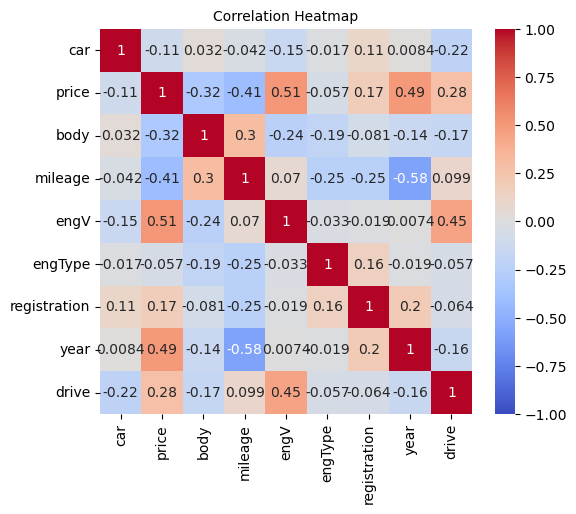

In [29]:
corr = df.corr()
plt.figure(figsize=(6, 5))
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':10});

#### EX7: Which variables are more correlated with the target?

**Solution:** Looking at the correlation matrix, the variables most strongly correlated with price are year, mileage, and engV, which is consistent with the qualitative insights we already anticipated in EX4. Year shows a clear positive correlation with price, confirming that newer cars tend to be more expensive (as anticipated), while mileage has a clear negative correlation, indicating that as the number of kilometers increases, the expected selling price decreases (also as anticipated). EngV has the strongest positive correlation with price, which aligns with the idea that cars with larger engines, usually more powerful or high-end, command higher prices on average. Yet, it's a bit surprising, since we already mentionned the distribution seen in EX4 was not fully linear and was a bit noisy, but with this correlation we can confidently confirm its strong correlation, as suspected.

The brand variable car, after being label-encoded, also shows a noticeable correlation with price, but not as strong as year or mileage. Personally, the correlation is weaker than expected, I would believe the brand would have a bigger impact than what this correlation shows. This suggests that brand still contributes important information (capturing premium vs. mainstream positioning), but that age, engine volume and usage of the car are far more decisive factors in explaining price variation. In contrast, variables such as engType, drive, and registration show relatively low correlations with price, which supports the idea from EX4 that they might play a secondary role.

## Model training

In [30]:
#Let's split train and test data
X = df.drop("price", axis=1)
y = df["price"]
X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=42)

#### Ensure X and Y have the same lenght for both train and test

In [31]:
print("Lenght X_train:",len(X_train))
print("Length y_train:", len(y_train))
print("Lenght X_test:",len(X_test))
print("Length y_test:", len(y_test))

Lenght X_train: 6168
Length y_train: 6168
Lenght X_test: 2056
Length y_test: 2056


#### Try different models:

In [32]:
#Linear Regression:

linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
display(linear_reg)

y_pred_test = linear_reg.predict(X_test)
error = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("${:,.02f}".format(error))

LinearRegression()

$9,344.01


In [33]:
#Random Forest:

random_forest_reg = RandomForestRegressor(random_state=0)
random_forest_reg.fit(X_train, y_train)
display(random_forest_reg)

y_pred_test = random_forest_reg.predict(X_test)
error = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("${:,.02f}".format(error))

RandomForestRegressor(random_state=0)

$4,322.87


In [34]:
#XGBoost:

lgb_reg = lgb.LGBMRegressor()
lgb_reg.fit (X_train, y_train)
display(lgb_reg)

y_pred_test=lgb_reg.predict(X_test)
error = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("${:,.02f}".format(error))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 6168, number of used features: 8
[LightGBM] [Info] Start training from score 14393.636463


LGBMRegressor()

$4,109.40


#### it seems that LightGBM performs better for this use case, so let's continue with the this algorithm grid search for choosing the best parameters (this can take some minutes):

In [35]:
# Add as many parametrers as you want
max_depth = [2, 8, 12]
n_estimators = [50, 100, 300]
learning_rate = [0.1]

parameters = {
    "max_depth": max_depth,
    "n_estimators": n_estimators,
    "learning_rate": learning_rate}

lgb_reg = lgb.LGBMRegressor(random_state=42, force_row_wise=True)

# Grid Search
gs = GridSearchCV(lgb_reg, parameters, scoring='neg_mean_squared_error')
gs.fit(X_train, y_train)

[LightGBM] [Info] Total Bins 409
[LightGBM] [Info] Number of data points in the train set: 4934, number of used features: 8
[LightGBM] [Info] Start training from score 14477.580131
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

GridSearchCV(estimator=LGBMRegressor(force_row_wise=True, random_state=42),
             param_grid={'learning_rate': [0.1], 'max_depth': [2, 8, 12],
                         'n_estimators': [50, 100, 300]},
             scoring='neg_mean_squared_error')

In [36]:
lgb_reg = gs.best_estimator_
lgb_reg.fit(X_train, y_train)

y_pred_test = lgb_reg.predict(X_test)

error = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("${:,.02f}".format(error))

print("The R2_score is:", r2_score(y_test, y_pred_test))

[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 6168, number of used features: 8
[LightGBM] [Info] Start training from score 14393.636463
$3,854.79
The R2_score is: 0.9252673105965709


#### EX8: Test with an invented example (just run the code and answer the questions):

In [42]:
A = []
Q = [
    "Enter your brand car "+  str(list(df_original['car'].unique()[:5]))[:-1]+" , ...]: ",
    "Enter the body category of your car "+ str(list(df_original['body'].unique()))+': ',
    "Enter the milage: ",
    "Enter the engV (use '.' as decimal): ",
    "Enter the engType "+ str(list(df_original['engType'].unique()))+': ',
    "Enter if it registered (yes/no): ",
    "Enter the year of the car: ",
    "Enter the drive type of the car "+ str(list(df_original['drive'].unique()))+': ']

for q in Q:
    a = input(q)
    A.append(a)

print("Your answers are:", A)

Your answers are: ['Mercedes-Benz', 'crossover', '250', '4.2', 'Diesel', 'yes', '2012', 'rear']


In [43]:
X_sample = np.array([A])

# Apply the encoder and data type corrections:
X_sample[:, 0] = str(X_sample[:, 0][0] if X_sample[:, 0][0] in list(df_original['car'].unique()) else 'Other')
X_sample[:, 0] = le_car.transform(X_sample[:,0])
X_sample[:, 1] = le_body.transform(X_sample[:,1])
X_sample[:, 4] = le_engType.transform(X_sample[:,4])
X_sample[:, 5] = int(1 if X_sample[:, 5][0] in yes_l else 0)
X_sample[:, 7] = le_drive.transform(X_sample[:,7])

X_sample = np.array([[
    int(X_sample[0, 0]),
    int(X_sample[0, 1]),
    int(X_sample[0, 2]),
    float(X_sample[0, 3]),
    int(X_sample[0, 4]),
    int(X_sample[0, 5]),
    int(X_sample[0, 6]),
    int(X_sample[0, 7])
]])

print('The encoded array is: ', X_sample)

The encoded array is:  [[2.600e+01 0.000e+00 2.500e+02 4.200e+00 0.000e+00 1.000e+00 2.012e+03
  2.000e+00]]


In [44]:
y_pred_sample = lgb_reg.predict(X_sample)
print("Your car estimated price is: ","${:,.02f}".format(y_pred_sample[0]))

Your car estimated price is:  $42,616.91


### Store and read the model

In [40]:
# Store
data = {"model": lgb_reg, "le_car": le_car, "le_body": le_body, "le_engType":le_engType , "le_drive":le_drive}
with open('model.pkl', 'wb') as file:
    pickle.dump(data, file)

In [41]:
# Read
with open('model.pkl', 'rb') as file:
    data = pickle.load(file)

model = data["model"]
le_car = data["le_car"]
le_body = data["le_body"]
le_engType = data["le_engType"]
le_drive = data["le_drive"]

y_pred_sample = model.predict(X_sample)
print("Your car estimated price is: ","${:,.02f}".format(y_pred_sample[0]))

Your car estimated price is:  $4,779.00


## Explainability AI

As an excellent data scientist, we cannot conclude our work without understanding how the model works. In this section of the project, we will apply SHAP as a technique to understand, debug and explain our model.

### Global explainability

#### EX9: Train a Shap explainer and calculate the shap_values object for the X_test dataset. Print the shap values object of the first sample of X_test.

In [47]:
import shap
shap.initjs()

# We use TreeExplainer as LightGBM is tree-based models, and TreeExplainer is more appropriate for these models
explainer = shap.TreeExplainer(lgb_reg, X_train)
shap_values = explainer(X_test)

display(X_test)
print(shap_values[0])

 97%|=================== | 1999/2056 [00:24<00:00]       

,car,body,mileage,engV,engType,registration,year,drive
4768,27,2,350,1.8,3,1,1990,0
7720,26,1,140,1.7,1,1,2007,0
4300,29,3,285,1.6,3,1,2001,0
8408,12,5,110,1.9,0,1,2008,0
2919,43,3,330,2.8,1,1,1994,0
...,...,...,...,...,...,...,...,...
3776,35,1,91,1.8,3,1,2011,0
7335,43,2,10,1.6,0,1,1984,2
5725,43,3,102,1.8,3,1,2011,0
4667,3,3,400,2.8,3,1,1998,2


.values =
array([ -301.37632308,  -106.83672633,  -666.20256309,  -244.91473192,
          74.90739225,    47.7806849 , -7419.19664168,  -377.40466124])

.base_values =
11974.468337506503

.data =
array([2.70e+01, 2.00e+00, 3.50e+02, 1.80e+00, 3.00e+00, 1.00e+00,
       1.99e+03, 0.00e+00])


#### EX10: Which is the average price cost prediction for all cars?

In [48]:
# We use the LightGBM model predictions on X_test (y_pred_test)
avg_pred_price = y_pred_test.mean()
print("Average predicted price on X_test:", "${:,.02f}".format(avg_pred_price))


Average predicted price on X_test: $13,730.34


**Solution:** $13,730.34

#### Let's plot the summary plot and bar plot for global explainability of the model.

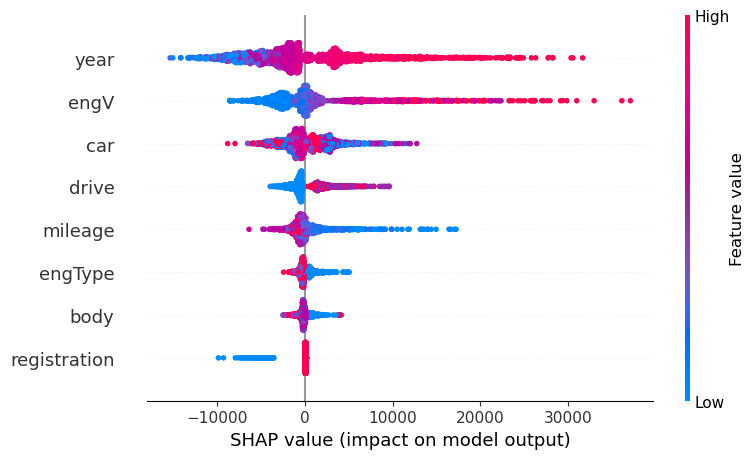

In [49]:
#Global Explainability
shap.summary_plot(shap_values, X_test)

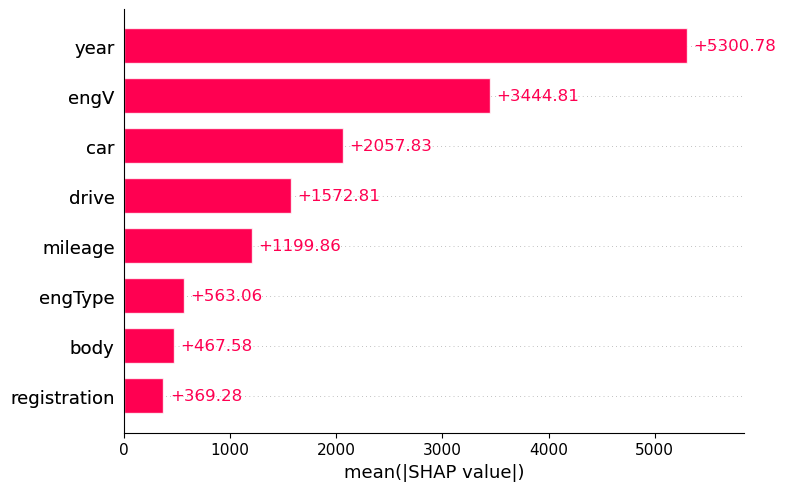

In [50]:
#Plot var: built from column 1 of all shap_values
shap.plots.bar(shap_values)

#### EX11: Which are your insights?

**Solution:** The global SHAP plots confirm and refine the hypotheses we formed earlier from the visual exploration (EX4) and the correlation analysis (EX7): the dominant drivers of the model’s predictions are **year**, **mileage**, **engV** and **car**. 

High values of year (recent models) are predominantly associated with positive SHAP values, whereas older cars tend to have negative contributions, confirming that age is one of the main determinants of price. 

For mileage, the pattern is inverted: low mileage is linked to positive SHAP values and high mileage to negative ones, which quantifies the depreciation effect already suggested by the scatterplots in EX4. 

For engV, higher engine volumes tend to have positive SHAP values, especially for medium‑to‑large engines, supporting the idea that more powerful or higher‑segment cars are priced higher and refining the moderate positive correlation we observed earlier by showing how this effect appears at the level of individual predictions. 

Finally, the behaviour of car (brand) in the SHAP bar and summary plots indicates that some brands systematically contribute positively to the predicted price (luxury or high‑end manufacturers), while others contribute negatively (more budget‑oriented brands), which matches our earlier qualitative assessment that brand captures an intrinsic value related to reputation, perceived quality and segment positioning. Actually, this confirms the initial belief that this was a heavy predictor, which we put in doubt after seeing the correlation matrix, but now we can confidently say that the car brand is a strong predictor.

In contrast, variables such as engType, drive and registration appear much lower in the SHAP importance ranking, with smaller SHAP magnitudes overall: they can slightly adjust the prediction for specific cars, but they do not drive the main structure of price variation compared to the four main features above.

#### Let's do deep dive in the variables `Mileage`, `engV` and `year`. 

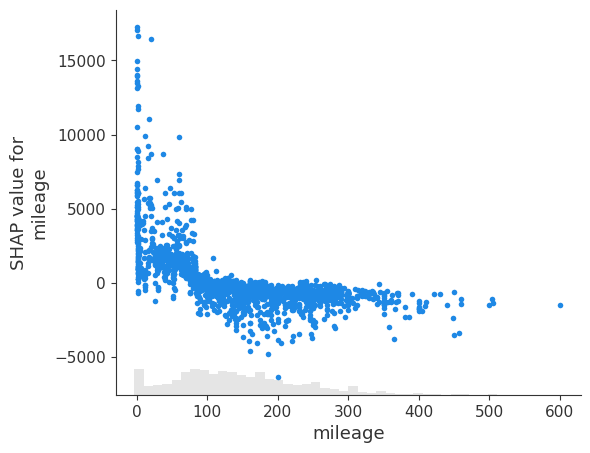

In [51]:
shap.plots.scatter(shap_values[:,"mileage"])

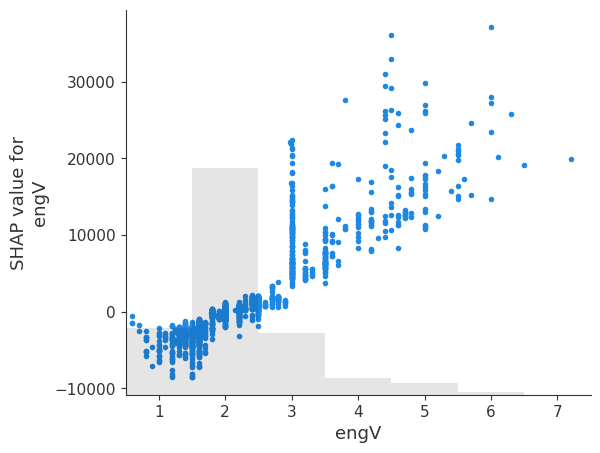

In [52]:
shap.plots.scatter(shap_values[:,"engV"])

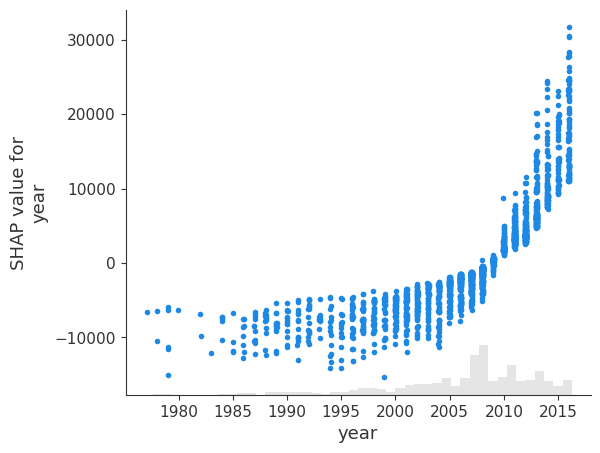

In [53]:
shap.plots.scatter(shap_values[:,"year"])

#### EX12: What are the most relevant insights abour the evolution of the features' values and their Shap values.

**Solution:** The SHAP scatter plots for mileage, engV and year show very clear and intuitive patterns that are consistent with our previous findings. For mileage, low values cluster around positive SHAP values (increasing the predicted price), while high mileage points are mostly associated with negative SHAP values, which means that additional kilometers almost always reduce the model’s price estimate. The transition from positive to negative contributions is smooth rather than abrupt, reflecting a gradual depreciation. For year, the pattern is reversed: newer cars (higher years) tend to have clearly positive SHAP values, and older cars have negative ones, confirming that the model systematically rewards recency and penalizes age.

In the case of engV, we observe that very small engines contribute negatively or only weakly to the prediction, whereas medium‑to‑large engines increasingly generate positive SHAP values, especially in the upper part of the engV range. This indicates that engine size acts as a continuous premium factor: larger engines tend to push the predicted price upwards even after controlling for the other variables. Overall, these plots confirm that the model has learned smooth, monotonic relationships for the three variables: more mileage consistently lowers the predicted price, more recent years consistently increase it, and larger engines tend to increase it as well, in line with both domain knowledge and the global importance patterns discussed in EX11.

#### Let's analyze the relationship of the variables `engV` and `year` and their Shap values according to the value of `mileage`.

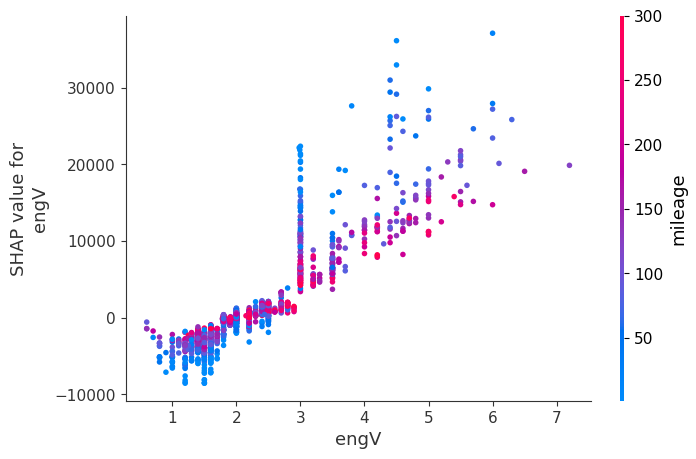

In [54]:
#Let's analyze the evolution of Shap values of engV based on mileage
shap.dependence_plot("engV", shap_values.values, X_test, interaction_index= "mileage")

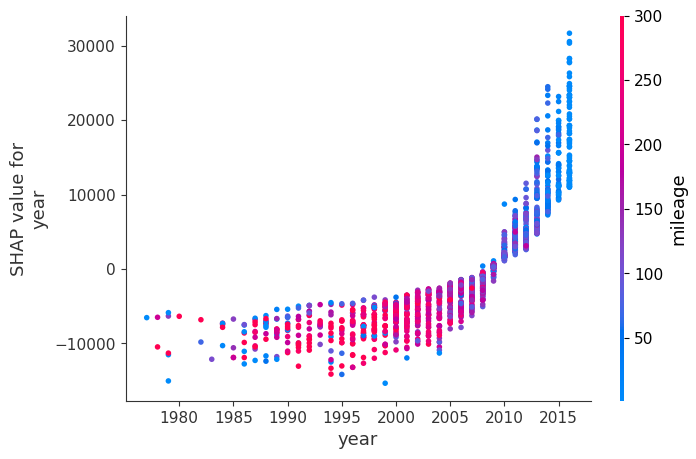

In [55]:
#Let's analyze the evolution of Shap values of engV based on mileage
shap.dependence_plot("year", shap_values.values, X_test, interaction_index= "mileage")

 #### EX13: What are the most relevant insights about the evolution of the features' values and their Shap values.

**Solution:** The SHAP dependence plots for engV and year, coloured by mileage, show that the effect of these variables on price is not only monotonic but also moderated by how much the car has been used. For engV, larger engines almost always have positive SHAP values, but this effect is strongest when mileage is low (blue points): powerful, low‑mileage cars receive a clear price premium, whereas for very high‑mileage cars (red points) the positive impact of a large engine is noticeably reduced. This means that a big engine can increase the predicted price, but its benefit is partially “eroded” if the car has been driven a lot.

A similar interaction appears for year: recent models (high year) show strong positive SHAP values when mileage is relatively low, but as mileage increases, those positive contributions shrink and can even become close to neutral. In contrast, old cars with very high mileage combine two negative effects (age and usage) and therefore show strongly negative SHAP values. Overall, these interaction plots reinforce the idea that the model has learned realistic behaviour: engine size and recency are valuable, but their positive impact on price is conditional on mileage not being too high, capturing the intuitive trade‑off between performance/modernity and wear.

### Local explainability

Local explainability facilitates the understanding of the prediction for some particular cases. In other words, XAI closes to a personalized prediction explainability. Let's use the first sample of X_test for the following steps.

#### Using the waterfall, force and decision plots, we can explain how the model works.

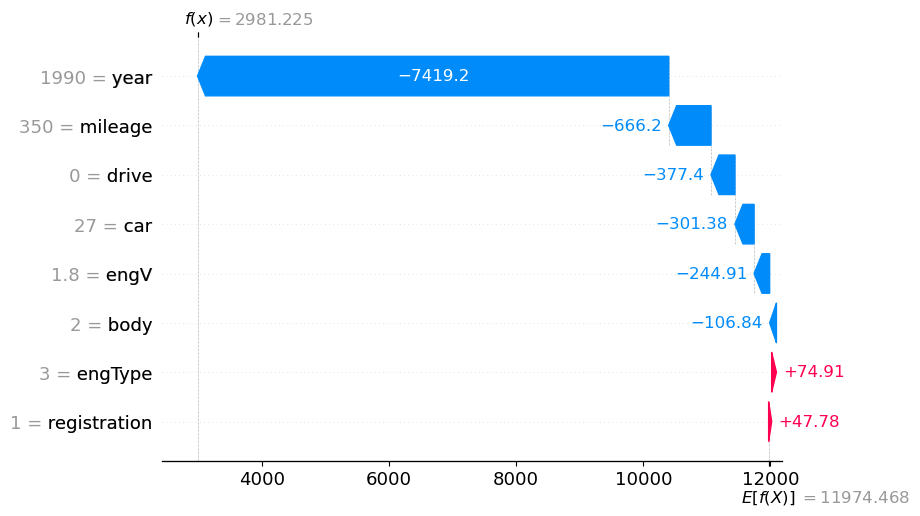

In [56]:
shap.plots.waterfall(shap_values[0])

In [57]:
shap.plots.force(shap_values[0])

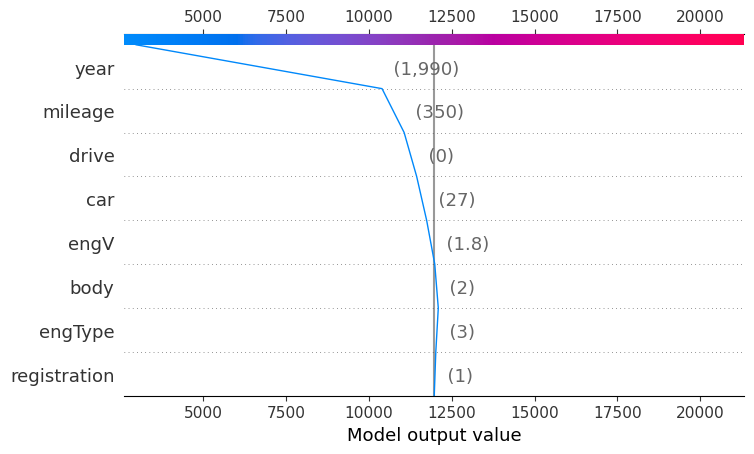

In [58]:
shap.decision_plot(shap_values[0].base_values,shap_values[0].values, X_test.iloc[0])